**EDA**

Saving FULL DATA_UPDATE (2).xlsx to FULL DATA_UPDATE (2).xlsx
Resume Dataset Summary:
- Total resumes: 584
- Label distribution: {'senior': 238, 'junior': 226, 'mid': 120}

Resume Length Statistics:
- Mean: 462.65 words
- Std: 606.81 words
- Min: 80, Max: 3712
- Most resumes are between 137 and 602 words long (middle 50%)

Top 10 Job Titles:
- Frontend Developer: 15 resumes
- DevOps Engineer: 14 resumes
- QA Automation Engineer: 11 resumes
- Backend Developer: 11 resumes
- Full Stack Developer: 10 resumes
- product analyst: 8 resumes
- frontend developer: 7 resumes
- data analyst: 7 resumes
- DevOps engineer: 7 resumes
- QA engineer: 7 resumes

📖 Most Common Words in Resumes:
- Top words include: data, using, confidential, experience, sql


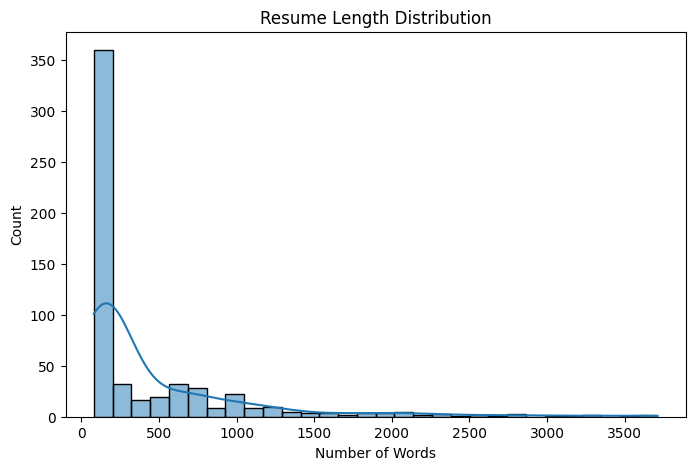

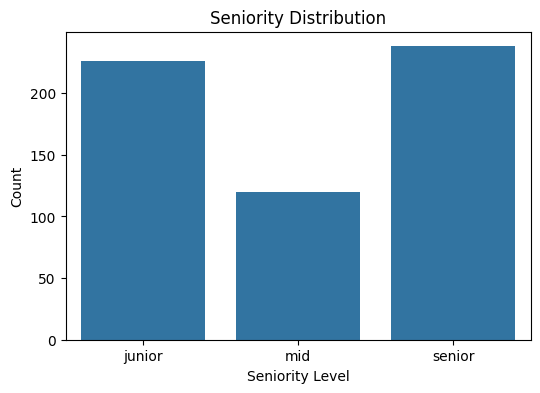

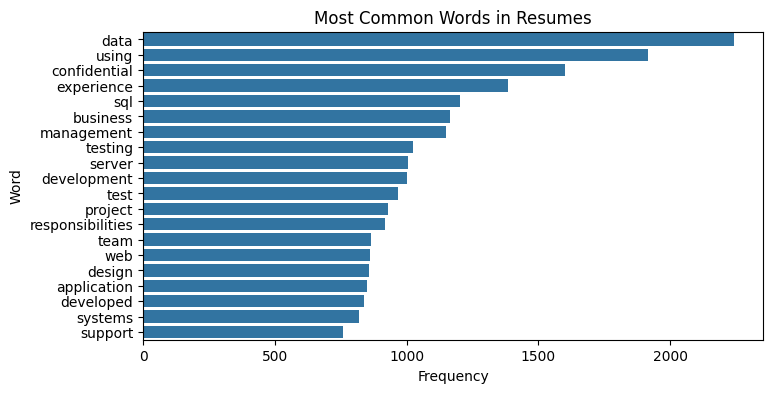

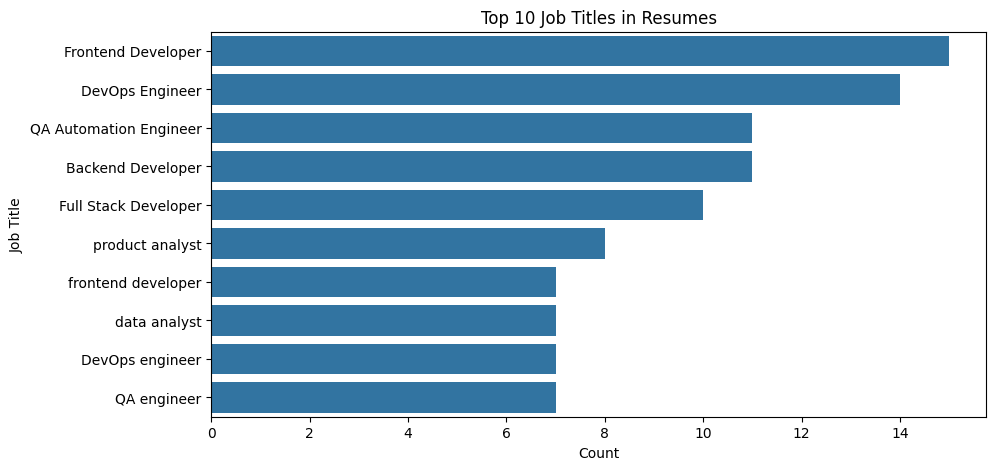

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import io
from google.colab import files

# Upload Excel file from local
uploaded = files.upload()
first_file = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[first_file]))

# Drop rows with missing required columns
df = df.dropna(subset=['Resume', 'Seniority', 'Job Title'])

# Normalize Seniority labels (e.g., 'Mid' → 'mid')
df['Seniority'] = df['Seniority'].str.strip().str.lower()

# Count number of words in each resume
df['word_count'] = df['Resume'].apply(lambda x: len(str(x).split()))

# Extract general statistics
num_samples = len(df)
label_counts = df['Seniority'].value_counts().to_dict()
length_stats = df['word_count'].describe()
top_titles = df['Job Title'].value_counts().head(10)

# Get most common words using CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=20)
cv_fit = cv.fit_transform(df['Resume'])
word_freq = pd.DataFrame({'word': cv.get_feature_names_out(), 'freq': cv_fit.toarray().sum(axis=0)})
word_freq = word_freq.sort_values(by='freq', ascending=False)
common_words = word_freq.head(5)['word'].tolist()

# 📋 Summary lines ready to paste into slide
summary = []
summary.append("Resume Dataset Summary:")
summary.append(f"- Total resumes: {num_samples}")
summary.append(f"- Label distribution: {label_counts}")
summary.append("")
summary.append("Resume Length Statistics:")
summary.append(f"- Mean: {round(length_stats['mean'], 2)} words")
summary.append(f"- Std: {round(length_stats['std'], 2)} words")
summary.append(f"- Min: {int(length_stats['min'])}, Max: {int(length_stats['max'])}")
summary.append(f"- Most resumes are between {int(length_stats['25%'])} and {int(length_stats['75%'])} words long (middle 50%)")
summary.append("")
summary.append("Top 10 Job Titles:")
for title, count in top_titles.items():
    summary.append(f"- {title}: {count} resumes")
summary.append("")
summary.append("📖 Most Common Words in Resumes:")
summary.append(f"- Top words include: {', '.join(common_words)}")

# Print final summary block
print("\n".join(summary))

# 📊 Plots

# Resume length distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title("Resume Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

# Seniority level distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Seniority', order=['junior', 'mid', 'senior'])
plt.title("Seniority Distribution")
plt.xlabel("Seniority Level")
plt.ylabel("Count")
plt.show()

# Most common words
plt.figure(figsize=(8, 4))
sns.barplot(data=word_freq, x='freq', y='word')
plt.title("Most Common Words in Resumes")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

# Top 10 job titles
top_titles_df = df['Job Title'].value_counts().head(10).reset_index()
top_titles_df.columns = ['Job Title', 'Count']

plt.figure(figsize=(10, 5))
sns.barplot(data=top_titles_df, y='Job Title', x='Count')
plt.title("Top 10 Job Titles in Resumes")
plt.xlabel("Count")
plt.ylabel("Job Title")
plt.show()


**BASELINE**

Baseline Model: TF-IDF + Logistic Regression
- Input: combined job title and resume text
- Vectorization: TF-IDF with 1–2 grams, 5000 features
- Classifier: Logistic Regression
- Data split: 80/20 stratified by seniority

Evaluation Results:
- Accuracy: 81.2%
- F1-score per class:
  • Junior: 0.8
  • Mid: 0.84
  • Senior: 0.81

Confusion Matrix (rows = true, columns = predicted):
[[36  0  9]
 [ 3 18  3]
 [ 6  1 41]]


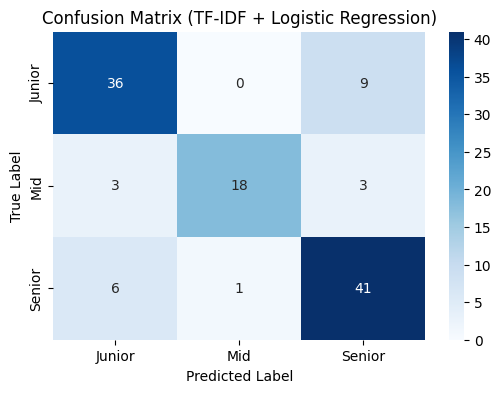

In [3]:
# Step 0: Upload + Prepare
from google.colab import files
import io
import pandas as pd

#uploaded = files.upload()
#first_file = next(iter(uploaded))
#df = pd.read_excel(io.BytesIO(uploaded[first_file]))

# Clean and normalize
df = df.dropna(subset=['Resume', 'Seniority', 'Job Title'])
df['Seniority'] = df['Seniority'].str.strip().str.lower()
df['combined_text'] = df['Job Title'].astype(str) + ' ' + df['Resume'].astype(str)

# Step 1: Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['combined_text'], df['Seniority'], test_size=0.2, random_state=42, stratify=df['Seniority']
)

# Step 2: TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Step 3: Model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

# Step 4: Evaluation
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred, labels=['junior', 'mid', 'senior'])

# Step 5: Summary for Slide
baseline_summary = []
baseline_summary.append("Baseline Model: TF-IDF + Logistic Regression")
baseline_summary.append("- Input: combined job title and resume text")
baseline_summary.append("- Vectorization: TF-IDF with 1–2 grams, 5000 features")
baseline_summary.append("- Classifier: Logistic Regression")
baseline_summary.append("- Data split: 80/20 stratified by seniority")
baseline_summary.append("")
baseline_summary.append("Evaluation Results:")
baseline_summary.append(f"- Accuracy: {round(report['accuracy'] * 100, 2)}%")
baseline_summary.append("- F1-score per class:")
for label in ['junior', 'mid', 'senior']:
    f1 = report[label]['f1-score']
    baseline_summary.append(f"  • {label.title()}: {round(f1, 2)}")
baseline_summary.append("")
baseline_summary.append("Confusion Matrix (rows = true, columns = predicted):")
baseline_summary.append(str(conf_matrix))

# Print summary for your slide
print("\n".join(baseline_summary))

# Step 6: Confusion Matrix Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Junior', 'Mid', 'Senior'],
            yticklabels=['Junior', 'Mid', 'Senior'])
plt.title("Confusion Matrix (TF-IDF + Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
